# Arbitrage Analysis #

Loading data from clickhouse

In [92]:

import pandas as pd
import clickhouse_connect
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", "{:.9f}".format)  # Ensure full decimal display

client = clickhouse_connect.get_client(host='localhost', port=8123, username='user', password='password')
df = client.query_df("SELECT * FROM arbitrage_details").drop_duplicates()
df['txn_timestamp'] = pd.to_datetime(df['txn_timestamp'], unit='s')

print(f"Loaded {len(df)} arbitrage txns from {df.txn_timestamp.min()} to {df.txn_timestamp.max()}")

Loaded 6963 arbitrage txns from 2024-03-08 18:30:00 to 2024-03-08 18:36:00


### Visualizations ###

##### Most arbitraged tokens #####

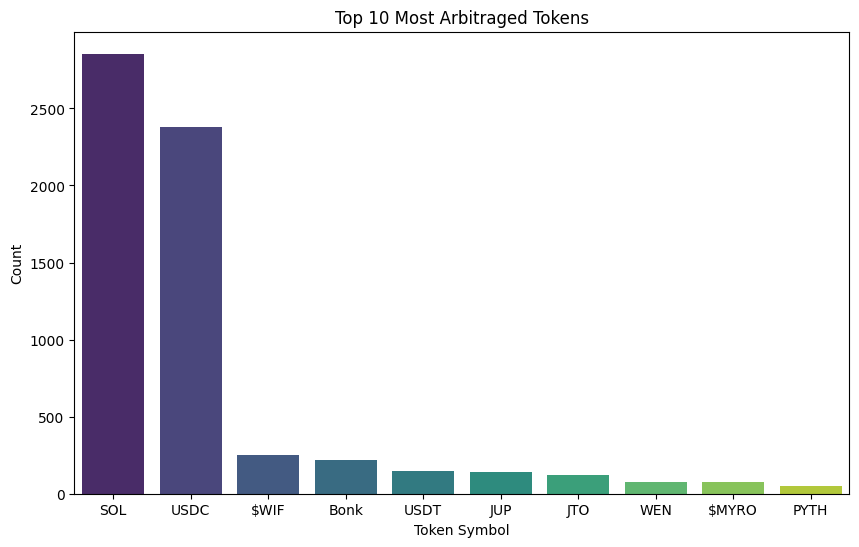

In [93]:
# Need to apply value counts to token_mint_addr column as it is the unique identifier for each token
# Might be possible to have same symbol for different tokens
token_arb_cts = df[['token_mint_addr', 'token_symbol']].value_counts()
token_arb_cts = token_arb_cts.reset_index().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=token_arb_cts['token_symbol'], y=token_arb_cts['count'], hue=token_arb_cts['token_symbol'], palette="viridis", legend=False)

plt.xlabel("Token Symbol")
plt.ylabel("Count")
plt.title("Top 10 Most Arbitraged Tokens")

# Show plot
plt.show()


##### Arbitrages over time #####

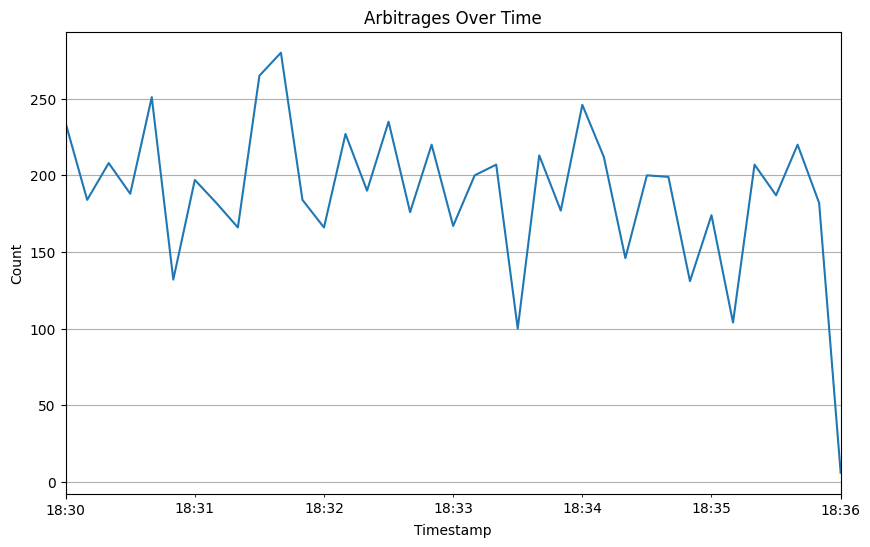

In [94]:
df_resampled = df.resample('10s', on='txn_timestamp').size()
plt.figure(figsize=(10, 6))
df_resampled.plot(kind='line')
plt.title('Arbitrages Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.grid(True)


### Summary Statistics ###

##### Total profit per token #####

In [95]:
token_filter_idx = df['token_mint_addr'].isin(token_arb_cts['token_mint_addr'])
total_profit = df[token_filter_idx].groupby(['token_mint_addr', 'token_symbol'])['token_amount'].sum().round(9)
total_profit.reset_index()[['token_symbol', 'token_amount']]

,token_symbol,token_amount
0,Bonk,4298781308.642720222
1,$WIF,67239.702639999
2,USDC,1515510.334976999
3,USDT,7145.633319000
4,PYTH,49752.220335000
5,$MYRO,15364.590812046
6,JUP,143789.258573000
7,SOL,17249.786612645
8,WEN,3147366462.793029308
9,JTO,14007.437086797


##### Median profit per token #####

In [96]:
median_profits = df[token_filter_idx].groupby(['token_mint_addr', 'token_symbol'])['token_amount'].median().round(9)
median_profits.reset_index()[['token_symbol', 'token_amount']]

,token_symbol,token_amount
0,Bonk,107000.000000000
1,$WIF,3.234500000
2,USDC,0.153082500
3,USDT,0.007676000
4,PYTH,0.007533500
5,$MYRO,2.690000000
6,JUP,0.209111000
7,SOL,0.002250284
8,WEN,1065.929230005
9,JTO,0.600000000


##### Most profitable txn per token #####

In [97]:
max_amount_per_group = df.groupby(['token_mint_addr', 'token_symbol'])['token_amount'].transform('max')
df.loc[token_filter_idx & (df['token_amount'] == max_amount_per_group), ['token_symbol', 'txn_hash', 'signer', 'token_amount']]


,token_symbol,txn_hash,signer,token_amount
711,JUP,2VnTZUuGaGYjxjVjzb8kHAmEsKkM5c8njtfMJgbG743rc1...,jupoGAk6QVHBtEdEUAsFhLRPCi5MK48bJZTu5AvBv6S,118704.000000000
829,SOL,2bPGrWoLHKgcq3eGTovLtCi99Upfpi8MkCDMMLaK5ZgGAx...,4EhZSMz5DMadWLzNmv8Mo2Du6yx67xbyRXEQjnNitywt,4297.888524419
1251,$MYRO,2shf7DSLKGP8jEkbLxhxQWV8aHteZNYQFRm9xuD2bVJdcT...,GPuQ4JceTXNEfayP3fdAncPqjp4y74QjzKwqFyPiebjR,10659.832873073
2566,WEN,3oWCJfFej5t7VajXpgso7TMfzbD2a3SWdKsRDY2miYtCEK...,4EhZSMz5DMadWLzNmv8Mo2Du6yx67xbyRXEQjnNitywt,3037681881.003229141
3823,PYTH,4dioS8KRR9jA2nzCtLvpxTzALyUicWbWV5sDwd99NbafZW...,GS8E7WcrNL9dW8epVzUETnVvqJGz1ysc1uhNZhMCSaKS,49059.000000000
4540,Bonk,57Mt3wwCvsevZ9dvn9CQjZN7fjfyHXNuoFi7WYewS2FHdg...,ASx1wk74GLZsxVrYiBkNKiViPLjnJQVGxKrudRgPir4A,3298000000.000000000
5484,$WIF,5ko6ZpaepKhhNmu9CkY9nwuuZ92j1yHkm4qj4qF2WfePAt...,MXHW21WwssFT46zoRMBPwCyfoKz8e2FBJ2ZrmeAG4gT,40338.805772000
5876,USDT,63wNvK57PXs29MpYreFkLy8zRUQDZUovqznhqPXpY5zF6V...,5JmNUiigwoigpgbEYuGs8jnPCDGvhnwigLXXpzvGorYg,1683.584659000
6594,JTO,ZDLs9beKSa1NDRuTcPLc7i1T2EjmxQm8Zs3CQoozqz7bUh...,GS8E7WcrNL9dW8epVzUETnVvqJGz1ysc1uhNZhMCSaKS,6337.200000000
6624,USDC,b5VUgyxVHgqPa9FEXkt2ttHFKMskstCdTHJksfHdZBLXX5...,ASx1wk74GLZsxVrYiBkNKiViPLjnJQVGxKrudRgPir4A,212895.672212000


##### Most common arbitrageurs #####

In [98]:
df.signer.value_counts().head(10)

signer
7rhxnLV8C77o6d8oz26AgK8x8m5ePsdeRawjqvojbjnQ    869
AxjdyLn3FPWUtGSaH7CPopyABv1XPQMifB3Kp37JNhmE    806
BEmUSjqs7mpgaSXw6QdrePfTsD8aQHbdtnqUxa63La6E    329
6v3nv8BUJKpXvnBnD4ZvpDiG3u847ALLYyo1NACn2zmV    269
71WDyyCsZwyEYDV91Qrb212rdg6woCHYQhFnmZUBxiJ6    250
EccxYg7rViwYfn9EMoNu7sUaV82QGyFt6ewiQaH1GYjv    159
ASx1wk74GLZsxVrYiBkNKiViPLjnJQVGxKrudRgPir4A    146
6DBRRXagTDX4yzGSpSZZLUv4LWzSehHWdFxPt4jk8KfT    144
NhiLaJ63BbechNdRnsnS57aA1bxh9eNfRDmnXNds6ra     125
GS8E7WcrNL9dW8epVzUETnVvqJGz1ysc1uhNZhMCSaKS    116
Name: count, dtype: Int64

##### Confirmed arbitrage transactions #####
A few example transactions that were verified through Jito Explorer

In [99]:
arb_txns = ['N5H5Y9zqLmpuDpQbtNknECKnSZfPBkhTSZWSNcdYp9QQNB2cZqmrLMV9AcwopXjTBVqipSg6VCjSFEi7K6Zv5Gr',
            '5FDLfEMDZRyB8NotYXRmXNbnWeyuQUUtu2wV1BEbKrdnF4kowE1SSESV23zwS2KbvzuybooZStDfeieWj1VoSuLb',
            '5QYiWNdKNmYkQxFzB4d3CE3Mdsqq45UHoky8Qhb2oL7hAF7U6CT6j4rZPMbtE2TGToXXwZTFfxCBiWgkkTr1S4PJ',
            '4N5eBauamaHCPbfD7XaAfGck73dCEZY9MaHHmUwsbVGKBXwKMzXPoSpkwWkLm64ivL7QqzfNVX4S8KBvoY2TQQJ',
            '5iPtVnNwvxe2feR4um2GD7ZxvfUCJFbiU81MnG28uWc4C7HRJvcLtcEM2ff2RvDbSVU5TnuopKNUc94ziWVL9KkF']
df[df.txn_hash.isin(arb_txns)]

,txn_hash,signer,token_mint_addr,token_amount,token_symbol,was_successful,txn_fee,txn_timestamp,txn_block
3416,4N5eBauamaHCPbfD7XaAfGck73dCEZY9MaHHmUwsbVGKBX...,EZMNY1paxQn4EpKrDwWL1oBRBrhcVb5rVehTUF46sXEf,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,0.414492000,USDC,1,0.000009777,2024-03-08 18:35:47,252929996
4738,5FDLfEMDZRyB8NotYXRmXNbnWeyuQUUtu2wV1BEbKrdnF4...,BEmUSjqs7mpgaSXw6QdrePfTsD8aQHbdtnqUxa63La6E,So11111111111111111111111111111111111111112,0.000329000,SOL,1,0.000015086,2024-03-08 18:35:45,252929993
4972,5QYiWNdKNmYkQxFzB4d3CE3Mdsqq45UHoky8Qhb2oL7hAF...,BerGz9jsBVEsVyNDy4TxYdz1LhN6HzxGCYJXbwqASq9e,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,0.031804000,USDC,1,0.000008870,2024-03-08 18:35:45,252929992
4974,5QYiWNdKNmYkQxFzB4d3CE3Mdsqq45UHoky8Qhb2oL7hAF...,BerGz9jsBVEsVyNDy4TxYdz1LhN6HzxGCYJXbwqASq9e,HhJpBhRRn4g56VsyLuT8DL5Bv31HkXqsrahTTUCZeZg4,0.005303276,$MYRO,1,0.000008870,2024-03-08 18:35:45,252929992
5409,5iPtVnNwvxe2feR4um2GD7ZxvfUCJFbiU81MnG28uWc4C7...,DyKPgXTRFWUEFm5Hm2KrYEtg6kkZcVaviWagHt51qS6B,So11111111111111111111111111111111111111112,0.000479619,SOL,1,0.000055000,2024-03-08 18:35:47,252929998
6339,N5H5Y9zqLmpuDpQbtNknECKnSZfPBkhTSZWSNcdYp9QQNB...,6v3nv8BUJKpXvnBnD4ZvpDiG3u847ALLYyo1NACn2zmV,So11111111111111111111111111111111111111112,0.001962093,SOL,1,0.000043353,2024-03-08 18:35:45,252929991


#### Further Analysis ####
Some additional questions that would be interesting to explore include
- How does arbitrage change over time with respect to individual tokens? In terms of both profit and number of arbitrage opportunities
- Who are the top traders for individual tokens?
- Any correlations between arbitrage profits and txn fees? Are larger arbitrage opportunities more competitive and correlated with higher txn fees?
